# Causal probabilistic programming without tears

Despite the tremendous progress over the last two decades in reducing
causal inference to statistical practice, the \"causal revolution\"
proclaimed by Judea Pearl and others remains incomplete, with a sprawling and
fragmented literature inaccessible to non-experts and still somewhat
isolated from cutting-edge machine learning research and software tools.

Functional probabilistic programming languages are promising substrates for bridging this gap thanks to the close correspondence between their operational semantics and the field’s standard mathematical formalism of structural causal models. 

In this tutorial we elaborate on this idea with three key observations inspiring Causal Pyro's design, and outline a causal Bayesian workflow for using Causal Pyro to answer causal questions.

## Observation 1: causal models are probabilistic programs

Probabilistic programmers typically think of their code as defining a
probability distribution over a set of variables, but programs often contain
more information than just the joint distributions they induce. In practice,
when we write probabilistic programs in languages like Pyro we often bring
to bear knowledge of causal relationships between variables, and implicitly,
how changes to one variable would propagate to changes in others.

Formally, a causal model specifies a *family* of probability
distributions, indexed by a set of *interventions*. An intervention
represents a hypothetical change to the domain, under which we'd
expect the joint distribution over the variables of interest to change.

To ground this out a bit more concretely, consider the following Pyro program
describing the joint distribution over three random variables, *stress*, *smokes*,
and *cancer*. We'll call this model an `observational_model` for reasons that will
become apparent when we want to reason about cause and effect later.

In [6]:
import pyro
import torch
from pyro.distributions import Bernoulli

def observational_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress])).long()
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

Our `observational_model` takes as input three sets of parameters, here just marginal and conditional probability tables, 
and returns a sample from the joint distribution over a single individual's *stress*, *smokes*, and *cancer* attributes.

Using Pyro's `plate` effect handler, we can easily sample repeatedly from the `observational_model`
to yield a joint distribution of an entire population of individual's attributes. For now we'll just 
choose some parameters by hand, but later we'll see how we can use Pyro's inference to infer likely
parameters from data.

In [24]:
stress_pt = torch.tensor([0.5])
smokes_cpt  = torch.tensor([0.1, 0.5])
cancer_cpt  = torch.tensor([[0.05, 0.3], [0.1, 0.35]])

n_individuals = 10000

with pyro.plate("individuals", n_individuals, dim=-1):
    stress_obs, smokes_obs, cancer_obs = observational_model(stress_pt, smokes_cpt, cancer_cpt)

Let's pretend for a moment that we're only interested in the relationship between whether individuals smoke
and how likely they are to get cancer. Let's visualize our simulated population!

[Text(0.5, 1.0, 'Observational Data')]

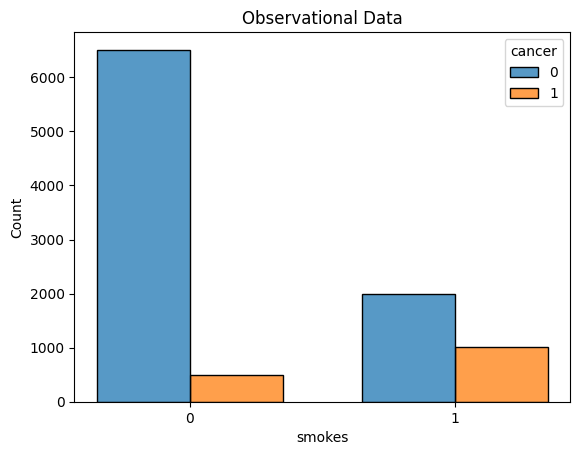

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

obs_data = torch.concat((stress_obs.reshape(-1, 1), smokes_obs.reshape(-1, 1), cancer_obs.reshape(-1, 1)), axis=-1)

obs_frame = pd.DataFrame(obs_data.numpy(), columns=["stressed", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})

sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=obs_frame).set(title='Observational Data')

As we can see clearly, our model tells us that individuals who smoke are much more likely to get cancer than individuals
who don't. Of the ~7,000 simulated individuals who don't smoke only ~500 got cancer, roughly 7% of the non-smokers. Of the 
remaining ~3,000 simulated individuals who did smoke ~1,000 individuals got cancer, a much high 33% of the smoking population.

So far we have a program that describes the distribution over data given model parameters. 
Somewhat more abstractly, we can imagine this process of simulating from a model as we've done above
with the following (somewhat cartoonish) diagram. Here, each point in "model space" or "parameter space"
induces a joint distribution over data.

(TODO: replace SCM with "program" and change colors a bit.)

![title](figures/Conditional_Distribution_of_Data.png)



For example, in a model over the variables *smokes* and *cancer*, the
joint distribution would change under the experimental condition that
randomly assigns each participant to either smoke or not smoke. In
this example, the marginal probability of *smokes* is changed to 50%, 
regardless of the individual's attributes.

To ground this out a bit more concretely, consider the following two Pyro programs; 
an `observational_model` representing the scenario where each individual chooses whether to smoke or not and an `experimental_model`
representing the scenario where each individual's smoking behavior is assigned randomly.

In [35]:

def randomized_model(stressed_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stressed_pt)).long()
    # smokes no longer depends on stressed.
    smokes   = pyro.sample("smokes", Bernoulli(0.5)).long()
    cancer   = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

with pyro.plate("individuals", n_individuals, dim=-1):
    stress_exp, smokes_exp, cancer_exp = randomized_model(stress_pt, smokes_cpt, cancer_cpt)

[Text(0.5, 1.0, 'Experimental Data')]

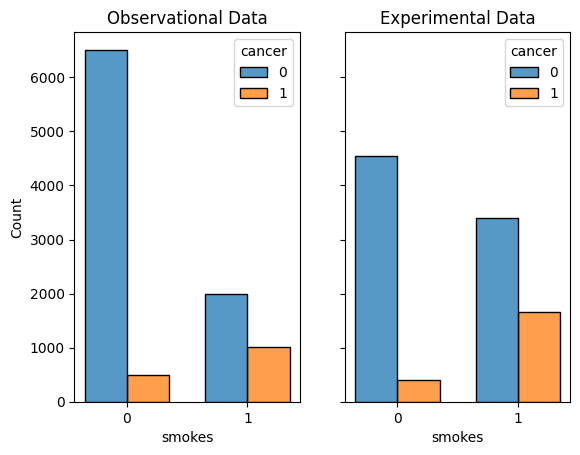

In [36]:
exp_data = torch.concat((stress_exp.reshape(-1, 1), smokes_exp.reshape(-1, 1), cancer_exp.reshape(-1, 1)), axis=-1)
exp_frame = pd.DataFrame(exp_data.numpy(), columns=["stressed", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})


_, ax = plt.subplots(1, 2, sharey=True)

sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=obs_frame, ax=ax[0]).set(title='Observational Data')
sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=exp_frame, ax=ax[1]).set(title='Experimental Data')

TODO: show cartoon like above of both observational and experimental simulation. However, we should remove the intervention transformation, to be introduced just after.

TODO: talk about how we want to construct these kinds of intervened models programmatically. (1) we may not always know how to create new models, (2) we're lazy and it's hard. This leads us to causal pyro.


In [32]:
from causal_pyro.query.do_messenger import do

def randomized_model_(stress_pt, smokes_cpt, cancer_cpt):
    assignment = pyro.sample("assignment", Bernoulli(0.5))
    return do(observational_model, {"smokes": assignment})(stress_pt, smokes_cpt, cancer_cpt)

with pyro.plate("individuals", n_individuals, dim=-1):
    stress_exp, smokes_exp, cancer_exp = randomized_model_(stress_pt, smokes_cpt, cancer_cpt)

TODO: edit below.



For one
thing, the marginal probability of *smokes* would be changed to 50%.)

In probabilistic programs, we can understand interventions as **program
transformations**. For example, in the smoking/cancer model, the
experiment we considered above might be encoded as a program
transformation that replaces assignments to the *smokes* variable in the
true causal program with the line $smokes \sim bernoulli(0.5)$.

A probabilistic program specifies a causal model in that it
  1. specifies a "default" or "observational" joint distribution over the
variables of interest according to the usual semantics of probabilistic
programming languages
  2. encodes the necessary information to
determine the new joint distribution under an arbitrary intervention
(program transformation)---apply the transformation and derive the new
joint distribution.


## Observation 2: causal computations are probabilistic computations

Once we have a causal model, what can we use it for? We briefly describe
several problem types that practitioners of causal inference may be
interested in solving (but do not claim that this is an exhaustive
list):

-   **Causal discovery.** Given data (either observational, or collected
    under experimental conditions, or both), infer the underlying causal
    model, from a class of possible models.

-   **Parameter estimation.** Given data (either observational, or
    collected under experimental conditions, or both), and a causal
    model with unknown parameters $\theta$, infer plausible values of
    $\theta$.

-   **Causal effect estimation.** Given data (either observational, or
    collected under experimental conditions, or both), and a causal
    model (possibly with unknown structure or parameters), estimate a
    *causal effect*, e.g. the Average Treatment Effect or the Individual
    Average Treatment Effect. Such queries are designed to answer
    questions like, "On average, how much better would a patient fare if
    they were given one medication vs. another?"

-   **Counterfactual prediction.** Given observed data, and a causal
    model (possibly with unknown structure or parameters), estimate a
    *counterfactual query*, designed to answer questions like, "Given
    what we know about this patient (including their observed health
    outcome), how would their outcome have differed had we treated them
    differently?"

All of these questions can be posed in a Bayesian framework. In particular, 
causal discovery, parameter estimation, causal effect estimation, and counterfactual prediction can be framed as Bayesian inference in appropriately specified generative models.


The quantities over which we have uncertainty are:

-   the structure of the true causal model,

-   the parameters of the true causal model, and

-   the values of any latent variables posited by the true causal model,
    for each subject in our dataset. (In the presence of experimental
    data, we are also uncertain about the latent variables posited by
    the intervened version of the true causal model, for each subject in
    the experimental dataset.)

We can express priors over these quantities, and likelihoods that relate
them to the observations. For example, suppose we are uncertain about
the true model structure $m$, and its unknown parameters $\theta$, as
well as the values of latent variables $x$, but we have observed $y$ for
a number of subjects, indexed $j = 1, \dots, N$. Then the likelihood for
$y_j$ is $p(y_j \mid m, \theta, x_j) = m_\theta(y_j \mid x_j)$. If we
also have observations $y'$ from an experimental setting modeled by
intervention $i$, then the likelihood is
$p(y'_j \mid m, \theta, x_j) = \text{intervene}(m_\theta, i)(y'_j \mid x_j)$.

Having expressed a prior and a likelihood, posterior inference can
recover causal structures $m$ and parameters $\theta$. Causal effects
and counterfactuals can be estimated by introducing additional variables
representing hypothetical *potential outcomes*. Such constructions might
usefully be automated by probabilistic programming languages, at which
point existing PPL inference machinery could be applied to estimating
the posterior.


## Observation 3: causal uncertainty is probabilistic uncertainty

Bayesian causal inference places identifiability on a principled continuum of irreducible causal uncertainty.

On the surface, to claim that causal reasoning can be encapsulated by
probabilistic computation appears to be in direct conflict with Pearl's
insistence that causal and statistical concepts be kept
separate [@pearl2001bayesian]. As Pearl describes them, statistical
concepts are those that summarize the distribution over observed
variables.

The probabilistic computations that we discuss in this
documentation are different in-kind from these assumption-free
summaries of data, in that we aim compute to probabilities of *latent*
causal structure, effects, and counterfactuals. In our proposed
approach, causal probabilistic programs play the role of causal
assumptions, relating observations to the latent causal quantities of
interest.

Casting causal inference as a particular instantiation of probabilistic
inference does not change the reality that many causal conclusions
cannot be unambiguously identified from data, regardless of sample size.
How much of the mutual information between treatment and outcome is
attributable to latent confounding? Does A cause B or does B cause A? If
C were c, what would have happened to D? Answers to all of these
questions are often ambiguous. 

Surprisingly, most existing formulations
of causal inference avoid quantifying these uncertainties, instead
abandoning problems in which latent causal quantities cannot be uniquely
inferred from data.[^2] Instead, the probabilistic programming approach
we espouse here enables users to express their assumptions, compute the
resulting uncertainty, be it irreducible or not, and then make decisions
accordingly.

## A Causal Bayesian Workflow